# DATA IMPUTATION USING KNN

It identifies the K nearest neighbors (defaulting to Euclidean distance), calculates the mean or weighted mean of their available values, and uses that result to replace the missing data.

## EXPERIMENT 1

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
# Read the dataset from specified path
df = pd.read_csv('heart.csv')

# Display the first 2 rows of the dataset
df.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1


In [3]:
# Display summary information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In this example, only the columns related to age, sex, chest pain experience, resting blood pressure, cholesterol levels, fasting blood sugar, and resting electrocardiographic measurements are used from the given dataset.

In [4]:
# Check the missing values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
# List of columns to check value counts for
columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Loop through each column and print its value counts
for column in columns:
    print(f"Value counts for '{column}':")
    print(df[column].value_counts())
    print('\n')

Value counts for 'Sex':
Sex
M    725
F    193
Name: count, dtype: int64


Value counts for 'ChestPainType':
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64


Value counts for 'RestingECG':
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64


Value counts for 'ExerciseAngina':
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64


Value counts for 'ST_Slope':
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64




In [6]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# List of columns to apply label encoding
columns_to_encode = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Loop through the columns and apply label encoding
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

In [7]:
# Display the first 2 rows of the dataset
df.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1


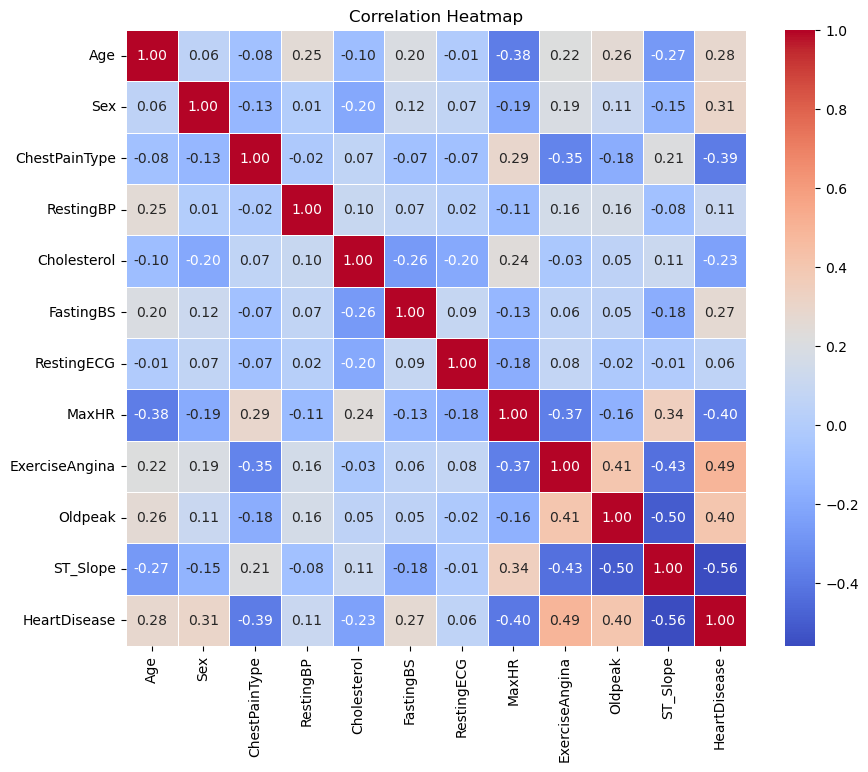

In [8]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the figure size
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

The heatmap of the heart disease dataset from Kaggle shows that the strongest correlation exists between the columns *ST_Slope* and *HeartDisease*. Therefore, in this experiment, I will apply KNN imputation only to these columns, as KNN imputation tends to perform poorly with values that have low or no correlation.

In [9]:
# Select only the 'ST_Slope' and 'HeartDisease' columns
subset_df = df[['ST_Slope', 'HeartDisease']]

# Check the dataset
subset_df.head(2)

,ST_Slope,HeartDisease
0,2,0
1,1,1


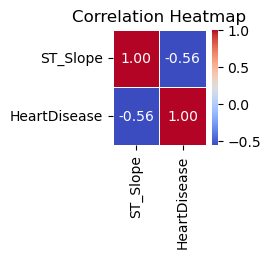

In [10]:
# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Set up the figure size
plt.figure(figsize=(1.5, 1.5))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

In [11]:
# Simulate missing values (as before)
np.random.seed(42)
subset_df = pd.DataFrame({'ST_Slope': np.random.rand(len(df))})
original_values = subset_df['ST_Slope'].copy()

In [12]:
# Simulate missing values: randomly remove 20 rows from 'ST_Slope' and replace with NaN
missing_indices = np.random.choice(subset_df.index, size=int(len(subset_df) * 0.2), replace=False)
subset_df.loc[missing_indices, 'ST_Slope'] = np.nan

In [13]:
# Check the simulated missing values
print(subset_df.isnull().sum())

ST_Slope    183
dtype: int64


In [14]:
# Feature columns
X = subset_df[['ST_Slope']].values

# Define possible values for n_neighbors
param_grid = {'n_neighbors': [1, 3, 5, 7, 10]}

In [15]:
# KNN Imputer with GridSearchCV
knn_imputer = KNNImputer()

# You can perform cross-validation, but here we just use it to find the best parameter.
grid_search = GridSearchCV(estimator=knn_imputer, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X)

# Best parameter
print(f"Best n_neighbors: {grid_search.best_params_['n_neighbors']}")

Best n_neighbors: 1


c:\Users\temulenbd\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\temulenbd\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\temulenbd\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\temulenbd\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
            

In [16]:
# Apply the best KNNImputer
best_knn_imputer = KNNImputer(n_neighbors=grid_search.best_params_['n_neighbors'])
df_imputed = pd.DataFrame(best_knn_imputer.fit_transform(subset_df[['ST_Slope']]), columns=['ST_Slope'])

In [17]:
# Impute missing values using KNN
df_imputed[['ST_Slope']] = knn_imputer.fit_transform(subset_df[['ST_Slope']])

In [18]:
# Calculate the Mean Squared Error (MSE) for the imputed values versus original values
missing_mask = subset_df['ST_Slope'].isna()

In [19]:
# Ensure original values and imputed values are aligned correctly for the missing rows
mse = mean_squared_error(original_values[missing_mask], df_imputed['ST_Slope'][missing_mask])

# Output the imputed data and MSE
print("Imputed Data:")
print(df_imputed)
print(f"\nMean Squared Error (MSE) of imputation: {mse}")

Imputed Data:
     ST_Slope
0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.496278
..        ...
913  0.409412
914  0.552047
915  0.436127
916  0.294466
917  0.496278

[918 rows x 1 columns]

Mean Squared Error (MSE) of imputation: 0.08162964062753586


In [ ]:
# Store the original values before imputation
original_values = df['ST_Slope'].copy()

# Impute missing values using KNN
df_imputed[['ST_Slope']] = knn_imputer.fit_transform(df_imputed[['ST_Slope']])

# Calculate the Mean Squared Error (MSE) for the imputed values versus original values
# We only compare where we had missing values
missing_mask = df['ST_Slope'].isna()

# Ensure original values and imputed values are aligned correctly for the missing rows
mse = mean_squared_error(original_values[missing_mask], df_imputed['ST_Slope'][missing_mask])

# Output the imputed data and MSE
print("Imputed Data:")
print(df_imputed)
print(f"\nMean Squared Error (MSE) of imputation: {mse}")

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

0.0827 is relatively small, indicating that the imputed values are quite close to the original values. This suggests that the KNN imputation is performing well, filling in the missing values in a reasonable manner.